# Libraries

In [1]:
%%capture
!pip install ydata-profiling 
!pip install pingouin
!pip install smote-variants

In [2]:
from ydata_profiling import ProfileReport
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pingouin as pg
from scipy.stats import chi2_contingency
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

from sklearn.utils import shuffle
import smote_variants as sv

# Data Load

In [3]:
output_data = pd.read_excel('output data.xlsx', sheet_name= 'output data')

# EDA

## Funcs

In [4]:
def df_col_info(df):
  col_names = [col_name for col_name in df.columns]
  nvals = [df[col_name].nunique() for col_name in df.columns]
  types = [df[col_name].dtype for col_name in df.columns]

  d = {
       'Unique Values': nvals, 
       'Data Type': types
       }

  return pd.DataFrame(data=d, index=col_names).sort_values(by=['Unique Values'])

In [5]:
def describe_object(df, col_name):
  print(f"\nCOLUMN: {col_name}")
  print(f"{df[col_name].nunique()} different values") 
  print(f"List of values:")
  print(df[col_name].value_counts(normalize=True))
  print('_'*50)

## General Info

In [6]:
output_data.sample(10).transpose()

,48870,1003,943,47544,56952,50837,9146,25430,906,41695
policy_id,ID02542,ID40378,ID33979,ID51071,ID31749,ID26823,ID33754,ID21402,ID30322,ID00007
age_driver,37,70,38,47,64,53,56,35,40,41
License_Type,0,0,0,0,0,0,0,0,0,0
area_cluster,C8,C8,C8,C7,C5,C8,C13,C8,C8,C7
is_ride_share,0,0,0,1,1,1,0,0,0,0
population_density,8794,8794,8794,6112,34738,8794,5410,8794,8794,6112
make,3,5,5,3,3,3,1,1,5,4
fuel_type,Diesel,Diesel,Diesel,Diesel,Diesel,Diesel,CNG,Petrol,Diesel,Diesel
airbags,6,2,2,6,6,6,2,2,2,2
is_adjustable_steering,Yes,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes


In [7]:
output_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58592 entries, 0 to 58591
Data columns (total 29 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   policy_id                         58592 non-null  object 
 1   age_driver                        58592 non-null  int64  
 2   License_Type                      58592 non-null  int64  
 3   area_cluster                      58592 non-null  object 
 4   is_ride_share                     58592 non-null  int64  
 5   population_density                58592 non-null  int64  
 6   make                              58592 non-null  int64  
 7   fuel_type                         58592 non-null  object 
 8   airbags                           58592 non-null  int64  
 9   is_adjustable_steering            58592 non-null  object 
 10  is_tpms                           58592 non-null  object 
 11  is_parking_sensors                58592 non-null  object 
 12  is_p

In [8]:
output_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age_driver,58592.0,44.058916,15.296827,18.000000,31.000000,44.00000,57.00000,70.000000
License_Type,58592.0,0.101857,0.302463,0.000000,0.000000,0.00000,0.00000,1.000000
is_ride_share,58592.0,0.175246,0.380180,0.000000,0.000000,0.00000,0.00000,1.000000
population_density,58592.0,18826.858667,17660.174792,290.000000,6112.000000,8794.00000,27003.00000,73430.000000
make,58592.0,1.763722,1.136988,1.000000,1.000000,1.00000,3.00000,5.000000
airbags,58592.0,3.137066,1.832641,1.000000,2.000000,2.00000,6.00000,6.000000
cylinder,58592.0,3.626963,0.483616,3.000000,3.000000,4.00000,4.00000,4.000000
gross_weight,58592.0,1385.276813,212.423085,1051.000000,1185.000000,1335.00000,1510.00000,1720.000000
Safety_rating,58592.0,1.759950,1.389576,0.000000,0.000000,2.00000,3.00000,5.000000
is_claim,58592.0,0.165842,0.371942,0.000000,0.000000,0.00000,0.00000,1.000000


In [9]:
df_col_info(output_data)

,Unique Values,Data Type
cylinder,2,int64
is_day_night_rear_view_mirror,2,object
is_driver_seat_height_adjustable,2,object
is_power_steering,2,object
is_central_locking,2,object
is_brake_assist,2,object
is_rear_window_defogger,2,object
is_rear_window_wiper,2,object
transmission_type,2,object
is_claim,2,int64


In [10]:
cols = list(output_data.drop(['age_driver', 'Prem', 'policy_id'], axis=1).columns)

In [11]:
cols

['License_Type',
 'area_cluster',
 'is_ride_share',
 'population_density',
 'make',
 'fuel_type',
 'airbags',
 'is_adjustable_steering',
 'is_tpms',
 'is_parking_sensors',
 'is_parking_camera',
 'rear_brakes_type',
 'cylinder',
 'transmission_type',
 'steering_type',
 'gross_weight',
 'is_rear_window_wiper',
 'is_rear_window_defogger',
 'is_brake_assist',
 'is_central_locking',
 'is_power_steering',
 'is_driver_seat_height_adjustable',
 'is_day_night_rear_view_mirror',
 'is_speed_alert',
 'Safety_rating',
 'is_claim']

In [12]:
for col_name in cols:
  describe_object(output_data, col_name)


COLUMN: License_Type
2 different values
List of values:
0    0.898143
1    0.101857
Name: License_Type, dtype: float64
__________________________________________________

COLUMN: area_cluster
22 different values
List of values:
C8     0.233035
C2     0.125307
C5     0.119112
C3     0.104127
C14    0.062466
C13    0.058421
C10    0.053847
C9     0.046662
C7     0.036985
C12    0.027120
C1     0.025055
C11    0.020685
C19    0.016248
C6     0.015190
C15    0.013159
C4     0.011350
C17    0.008397
C16    0.006844
C21    0.006468
C18    0.004130
C22    0.003533
C20    0.001860
Name: area_cluster, dtype: float64
__________________________________________________

COLUMN: is_ride_share
2 different values
List of values:
0    0.824754
1    0.175246
Name: is_ride_share, dtype: float64
__________________________________________________

COLUMN: population_density
22 different values
List of values:
8794     0.233035
27003    0.125307
34738    0.119112
4076     0.104127
7788     0.062466
5410  

## Missing and Duplicated values

In [13]:
output_data.isnull().sum().sum()

0

In [14]:
output_data.duplicated().sum()

0

## Categorical Features

### Irrelevant Data

In [15]:
df = output_data.iloc[:,].copy()

In [16]:
df = df.drop('policy_id', axis=1)

### Value Mappings

As a benchmark, it was decided to test a model with mapping values of categorical features to integers. 

Alternatively, one-hot dummy variables could/may be used.

In [17]:
to_map_y_n_cols = ['is_adjustable_steering', 
            'is_tpms', 
            'is_parking_sensors', 
            'is_parking_camera', 
            'is_rear_window_wiper', 
            'is_rear_window_defogger', 
            'is_brake_assist', 
            'is_central_locking', 
            'is_power_steering', 
            'is_driver_seat_height_adjustable', 
            'is_day_night_rear_view_mirror', 
            'is_speed_alert'
            ]


In [18]:
to_map_other_cols = ['fuel_type', 'rear_brakes_type', 'transmission_type', 'steering_type']

In [19]:
df[to_map_y_n_cols + to_map_other_cols].sample(10).transpose()

,8492,27767,39033,44329,31259,15637,8825,52144,42411,29080
is_adjustable_steering,No,Yes,Yes,No,Yes,No,No,Yes,Yes,Yes
is_tpms,No,No,No,No,No,No,No,Yes,No,No
is_parking_sensors,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes
is_parking_camera,No,No,Yes,Yes,No,No,No,Yes,No,No
is_rear_window_wiper,No,No,Yes,No,No,No,No,Yes,No,No
is_rear_window_defogger,No,No,Yes,Yes,No,No,No,Yes,No,No
is_brake_assist,No,Yes,Yes,Yes,Yes,No,No,Yes,No,Yes
is_central_locking,No,Yes,Yes,Yes,Yes,No,No,Yes,Yes,Yes
is_power_steering,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes
is_driver_seat_height_adjustable,No,Yes,Yes,Yes,Yes,No,No,Yes,No,Yes


In [20]:
for col in to_map_y_n_cols:
  df[col] = df.loc[:,col].map({'Yes': 1, 'No': 0})

In [21]:
df['fuel_type'] = df.loc[:,'fuel_type'].map({'Petrol': 0, 'CNG': 1, 'Diesel': 2})
df['rear_brakes_type'] = df.loc[:,'rear_brakes_type'].map({'Drum': 0, 'Disc': 1})
df['transmission_type'] = df.loc[:,'transmission_type'].map({'Manual': 0, 'Automatic': 1})
df['steering_type'] = df.loc[:,'steering_type'].map({'Power': 0, 'Electric': 1, 'Manual': 2})
df['area_cluster'] = df.loc[:,'area_cluster'].transform(lambda x: int(x[slice(1,len(x))]))

In [22]:
other_cols = [i for i in df.columns if i not in to_map_y_n_cols and i not in to_map_other_cols]

In [23]:
df_col_info(df[other_cols])

,Unique Values,Data Type
License_Type,2,int64
is_ride_share,2,int64
cylinder,2,int64
is_claim,2,int64
airbags,3,int64
make,5,int64
Safety_rating,5,int64
gross_weight,10,int64
area_cluster,22,int64
population_density,22,int64


In [24]:
categorical_attributes = to_map_y_n_cols + to_map_other_cols + [ 'License_Type', 'area_cluster', 'is_ride_share', 'make', 'Safety_rating']
# categorical_attributes

## Data Type Conversion

In [25]:
df[categorical_attributes].dtypes

is_adjustable_steering              int64
is_tpms                             int64
is_parking_sensors                  int64
is_parking_camera                   int64
is_rear_window_wiper                int64
is_rear_window_defogger             int64
is_brake_assist                     int64
is_central_locking                  int64
is_power_steering                   int64
is_driver_seat_height_adjustable    int64
is_day_night_rear_view_mirror       int64
is_speed_alert                      int64
fuel_type                           int64
rear_brakes_type                    int64
transmission_type                   int64
steering_type                       int64
License_Type                        int64
area_cluster                        int64
is_ride_share                       int64
make                                int64
Safety_rating                       int64
dtype: object

In [26]:
for col in categorical_attributes:
  df[col] = df[col].astype('category')

In [27]:
df[categorical_attributes].dtypes

is_adjustable_steering              category
is_tpms                             category
is_parking_sensors                  category
is_parking_camera                   category
is_rear_window_wiper                category
is_rear_window_defogger             category
is_brake_assist                     category
is_central_locking                  category
is_power_steering                   category
is_driver_seat_height_adjustable    category
is_day_night_rear_view_mirror       category
is_speed_alert                      category
fuel_type                           category
rear_brakes_type                    category
transmission_type                   category
steering_type                       category
License_Type                        category
area_cluster                        category
is_ride_share                       category
make                                category
Safety_rating                       category
dtype: object


# Feature Selection

Below are the methods for feature selection
- Effect size test - Cramer's V 
- Test for dependence/independence - chi-squared

Info about Cramer's V - https://www.ibm.com/docs/en/cognos-analytics/11.1.0?topic=terms-cramrs-v



## Cramer's V test

In [28]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt((chi2 / (n * (min(r, k) - 1))))

In [29]:
X = df.drop('is_claim', axis=1)
y = df['is_claim']

In [30]:
effSize_craimer = [cramers_v(X[i], y) for i in X.columns]
effSize_craimer = pd.Series(effSize_craimer,index = X.columns).sort_values(ascending = False)

In [31]:
effSize_craimer

Prem                                0.692620
is_ride_share                       0.473821
gross_weight                        0.362833
airbags                             0.341325
transmission_type                   0.301982
is_parking_camera                   0.274604
is_rear_window_wiper                0.265931
make                                0.263419
is_rear_window_defogger             0.251388
Safety_rating                       0.246546
is_tpms                             0.242516
rear_brakes_type                    0.242516
steering_type                       0.196319
fuel_type                           0.196064
is_power_steering                   0.188187
cylinder                            0.161332
is_brake_assist                     0.136968
is_driver_seat_height_adjustable    0.118064
is_adjustable_steering              0.104893
is_central_locking                  0.100319
is_parking_sensors                  0.071220
population_density                  0.065836
area_clust

In [32]:
features_size = list(effSize_craimer.loc[lambda x : x > 0.2].index)

In [33]:
features_size_rem = list(effSize_craimer.loc[lambda x : x <= 0.2].index)

In [34]:
features_size

['Prem',
 'is_ride_share',
 'gross_weight',
 'airbags',
 'transmission_type',
 'is_parking_camera',
 'is_rear_window_wiper',
 'make',
 'is_rear_window_defogger',
 'Safety_rating',
 'is_tpms',
 'rear_brakes_type']

In [35]:
features_size_rem

['steering_type',
 'fuel_type',
 'is_power_steering',
 'cylinder',
 'is_brake_assist',
 'is_driver_seat_height_adjustable',
 'is_adjustable_steering',
 'is_central_locking',
 'is_parking_sensors',
 'population_density',
 'area_cluster',
 'is_day_night_rear_view_mirror',
 'age_driver',
 'License_Type',
 'is_speed_alert']

## Chi-squared

In [36]:
# X = X[features_size]
X = X.drop(features_size_rem, axis=1)
test = SelectKBest(score_func=chi2)
fit = test.fit(X, y)

In [37]:
p_val = pd.Series(fit.pvalues_,index = X.columns).sort_values(ascending = True)

In [38]:
features_test = [i for i in p_val.index if p_val[i] <= 0.05]
features_rem = [i for i in p_val.index if p_val[i] > 0.05]

In [39]:
features_test

['is_ride_share',
 'airbags',
 'is_tpms',
 'is_parking_camera',
 'rear_brakes_type',
 'transmission_type',
 'gross_weight',
 'is_rear_window_wiper',
 'is_rear_window_defogger',
 'Prem',
 'make',
 'Safety_rating']

In [40]:
features_rem

[]

# Split

## Imbalanced

### All Features

In [41]:
X_all = df.drop('is_claim', axis=1)
y_all = df['is_claim']

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.3, random_state=1234)

### Selected Features

In [43]:
X_few = df.drop(['is_claim'], axis=1)
X_few = X_few[features_test]
y_few = df['is_claim']

In [44]:
X_train_few, X_test_few, y_train_few, y_test_few = train_test_split(X_few, y_few, test_size=0.3, random_state=1234)

## Balanced

SMOTE Oversampling method for data imbalance was selected.

Alternatively, wrapper methods such as Forward Selection, Backward Elimination, and Recursive Feature Elimination may be considered.

### All Features

In [45]:
print(f"Before OverSampling count of 1: {sum(y_train==1)}")
print(f"Before OverSampling count of 0: {sum(y_train==0)}")

Before OverSampling count of 1: 6758
Before OverSampling count of 0: 34256


In [46]:
oversampler= sv.SMOTE()
X_train_bal, y_train_bal = oversampler.sample(np.array(X_train), np.array(y_train))

2023-05-09 18:51:33,011:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': None, 'class_name': 'SMOTE'}")
INFO:smote_variants:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': None, 'class_name': 'SMOTE'}")
2023-05-09 18:51:33,019:INFO:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
INFO:smote_variants:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
2023-05-09 18:51:33,025:INFO:NearestNeighborsWithMetricTensor: kneighbors query minkowski
INFO:smote_variants:NearestNeighborsWithMetricTensor: kneighbors query minkowski
2023-05-09 18:51:33,517:INFO:SMOTE: simplex sampl

In [47]:
print('After OverSampling, the shape of train_X: {}'.format(X_train_bal.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(X_train_bal.shape))
print("After OverSampling, counts of label 1: {}".format(sum(y_train_bal==1)))
print("After OverSampling, counts of label 0: {}".format(sum(y_train_bal==1)))

After OverSampling, the shape of train_X: (68512, 27)
After OverSampling, the shape of train_y: (68512, 27) 

After OverSampling, counts of label 1: 34256
After OverSampling, counts of label 0: 34256


In [48]:
trainData = pd.concat([X_train,y_train],axis=1)

In [49]:
ind = trainData[trainData['is_claim']==1].index
print(len(ind))

6758


In [50]:
minData = trainData.loc[ind]
print(minData.shape)

(6758, 28)


In [51]:
ind1 = trainData[trainData['is_claim']==0].index
print(len(ind1))

34256


In [52]:
majData = trainData.loc[ind1]
print(majData.shape)

(34256, 28)


In [53]:
majSample = majData.sample(n=len(ind),random_state = 1234)

In [54]:
balData = pd.concat([minData,majSample],axis = 0)

In [55]:
balData.shape

(13516, 28)

In [56]:
balData = shuffle(balData)

In [57]:
balData.shape

(13516, 28)

In [58]:
X_train_bal = balData.drop('is_claim', axis=1)
y_train_bal = balData['is_claim']

### Seleted Features

In [59]:
print(f"Before OverSampling count of 1: {sum(y_train_few==1)}")
print(f"Before OverSampling count of 0: {sum(y_train_few==0)}")

Before OverSampling count of 1: 6758
Before OverSampling count of 0: 34256


In [60]:
oversampler= sv.SMOTE()
X_train_bal_few, y_train_bal_few = oversampler.sample(np.array(X_train_few), np.array(y_train_few))

2023-05-09 18:51:34,557:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': None, 'class_name': 'SMOTE'}")
INFO:smote_variants:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': None, 'class_name': 'SMOTE'}")
2023-05-09 18:51:34,565:INFO:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
INFO:smote_variants:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
2023-05-09 18:51:34,587:INFO:NearestNeighborsWithMetricTensor: kneighbors query minkowski
INFO:smote_variants:NearestNeighborsWithMetricTensor: kneighbors query minkowski
2023-05-09 18:51:34,666:INFO:SMOTE: simplex sampl

In [61]:
print('After OverSampling, the shape of train_X: {}'.format(X_train_bal_few.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(X_train_bal_few.shape))
print("After OverSampling, counts of label 1: {}".format(sum(y_train_bal_few==1)))
print("After OverSampling, counts of label 0: {}".format(sum(y_train_bal_few==1)))

After OverSampling, the shape of train_X: (68512, 12)
After OverSampling, the shape of train_y: (68512, 12) 

After OverSampling, counts of label 1: 34256
After OverSampling, counts of label 0: 34256


In [62]:
trainData_few = pd.concat([X_train_few,y_train_few],axis=1)

In [63]:
ind_few = trainData_few[trainData_few['is_claim']==1].index
print(len(ind_few))

6758


In [64]:
minData_few = trainData_few.loc[ind_few]
print(minData_few.shape)

(6758, 13)


In [65]:
ind1_few = trainData_few[trainData_few['is_claim']==0].index
print(len(ind1_few))

34256


In [66]:
majData_few = trainData_few.loc[ind1_few]
print(majData_few.shape)

(34256, 13)


In [67]:
majSample_few = majData_few.sample(n=len(ind_few),random_state = 1234)

In [68]:
balData_few = pd.concat([minData_few,majSample_few],axis = 0)

In [69]:
balData_few = shuffle(balData_few)

In [70]:
X_train_bal_few = balData_few.drop('is_claim', axis=1)
y_train_bal_few = balData_few['is_claim']

# Model Selection - DTree

## Imbalanced Data

### All Features

In [71]:
dt_model = DecisionTreeClassifier(max_depth=4)
dt_model.fit(X_train, y_train)
dt_model_y_pred = dt_model.predict(X_test)

#### test fo over/under fitting

In [72]:
dt_model_y_pred_test = dt_model.predict(X_test)
dt_model_y_pred_train = dt_model.predict(X_train)

test_acc = accuracy_score(y_test, dt_model_y_pred_test)
train_acc = accuracy_score(y_train, dt_model_y_pred_train)

print("Train accuracy:", train_acc)
print("Test accuracy:", test_acc)

Train accuracy: 0.858462963865997
Test accuracy: 0.8555580839685971


### Selected Features

In [73]:
dt_model_few = DecisionTreeClassifier(max_depth=4)
dt_model_few.fit(X_train_few, y_train_few)
dt_model_y_pred_few = dt_model_few.predict(X_test_few)

#### test fo over/under fitting

In [74]:
dt_model_y_pred_few_test = dt_model_few.predict(X_test_few)
dt_model_y_pred_few_train = dt_model_few.predict(X_train_few)

test_acc = accuracy_score(y_test, dt_model_y_pred_few_test)
train_acc = accuracy_score(y_train, dt_model_y_pred_few_train)

print("Train accuracy:", train_acc)
print("Test accuracy:", test_acc)

Train accuracy: 0.8584142000292583
Test accuracy: 0.8543634088064627


## Balanced Data

### All Features

In [75]:
dt_model_bal = DecisionTreeClassifier(max_depth=4)
dt_model_bal.fit(X_train_bal, y_train_bal)
dt_model_y_pred_bal = dt_model_bal.predict(X_test)

#### test fo over/under fitting

In [76]:
dt_model_y_pred_bal_test = dt_model_bal.predict(X_test)
dt_model_y_pred_bal_train = dt_model_bal.predict(X_train)

test_acc = accuracy_score(y_test, dt_model_y_pred_bal_test)
train_acc = accuracy_score(y_train, dt_model_y_pred_bal_train)

print("Train accuracy:", train_acc)
print("Test accuracy:", test_acc)

Train accuracy: 0.850002438191837
Test accuracy: 0.844123335988167


### Selected Features

In [77]:
dt_model_bal_few = DecisionTreeClassifier(max_depth=4)
dt_model_bal_few.fit(X_train_bal_few, y_train_bal_few)
dt_model_y_pred_bal_few = dt_model_bal_few.predict(X_test_few)

#### test fo over/under fitting

In [78]:
dt_model_y_pred_bal_few_test = dt_model_bal_few.predict(X_test_few)
dt_model_y_pred_bal_few_train = dt_model_bal_few.predict(X_train_few)

test_acc = accuracy_score(y_test, dt_model_y_pred_bal_few_test)
train_acc = accuracy_score(y_train, dt_model_y_pred_bal_few_train)

print("Train accuracy:", train_acc)
print("Test accuracy:", test_acc)

Train accuracy: 0.8569025210903594
Test accuracy: 0.8531687336443281


# Evaluation - DTree

## Imbalanced Data

### All Features

In [79]:
dt_model_confmat = confusion_matrix(y_test, dt_model_y_pred)
dt_model_confmat_disp = ConfusionMatrixDisplay(confusion_matrix=dt_model_confmat,display_labels=dt_model.classes_)
dt_model_confmat_disp.confusion_matrix

array([[13126,  1493],
       [ 1046,  1913]])

In [80]:
accuracy_score(y_test, dt_model_y_pred)

0.8555580839685971

In [81]:
precision_score(y_test, dt_model_y_pred)

0.5616559013505579

In [82]:
recall_score(y_test, dt_model_y_pred) 

0.6465021966880703

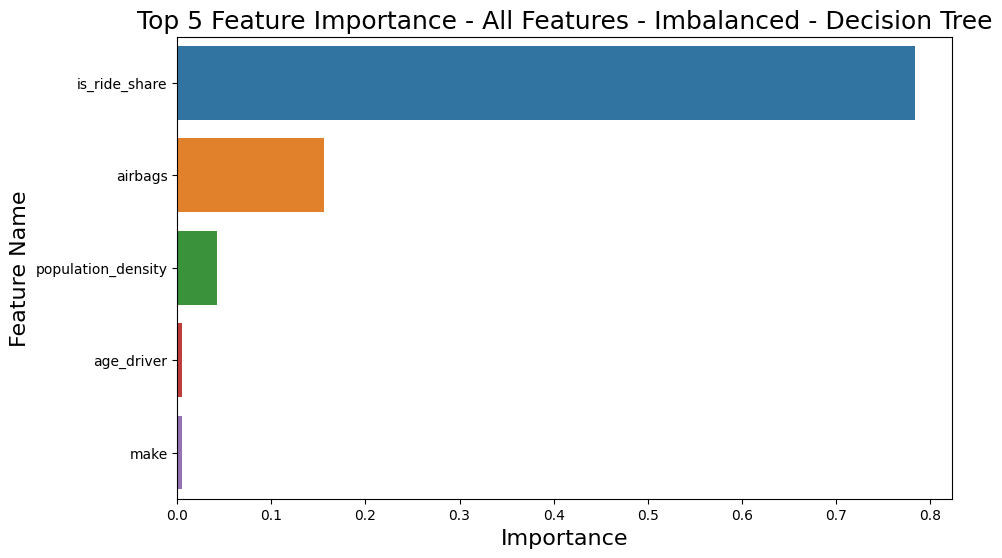

In [83]:
imp_df = pd.DataFrame(
    {"Feature Name": X_train.columns,
     "Importance": dt_model.feature_importances_})

fi = imp_df.sort_values(by="Importance", ascending=False)
fi_top5 = fi.head()

plt.figure(figsize=(10,6))
sns.barplot(data=fi_top5, x="Importance", y="Feature Name")
plt.title("Top 5 Feature Importance - All Features - Imbalanced - Decision Tree", fontsize=18)
plt.xlabel("Importance", fontsize=16)
plt.ylabel("Feature Name", fontsize=16)
plt.show()

### Selected Features

In [84]:
dt_model_confmat = confusion_matrix(y_test_few, dt_model_y_pred_few)
dt_model_confmat_disp = ConfusionMatrixDisplay(confusion_matrix=dt_model_confmat,display_labels=dt_model.classes_)
dt_model_confmat_disp.confusion_matrix

array([[13164,  1455],
       [ 1105,  1854]])

In [85]:
accuracy_score(y_test_few, dt_model_y_pred_few)

0.8543634088064627

In [86]:
precision_score(y_test_few, dt_model_y_pred_few)

0.5602901178603807

In [87]:
recall_score(y_test_few, dt_model_y_pred_few) 

0.6265630280500168

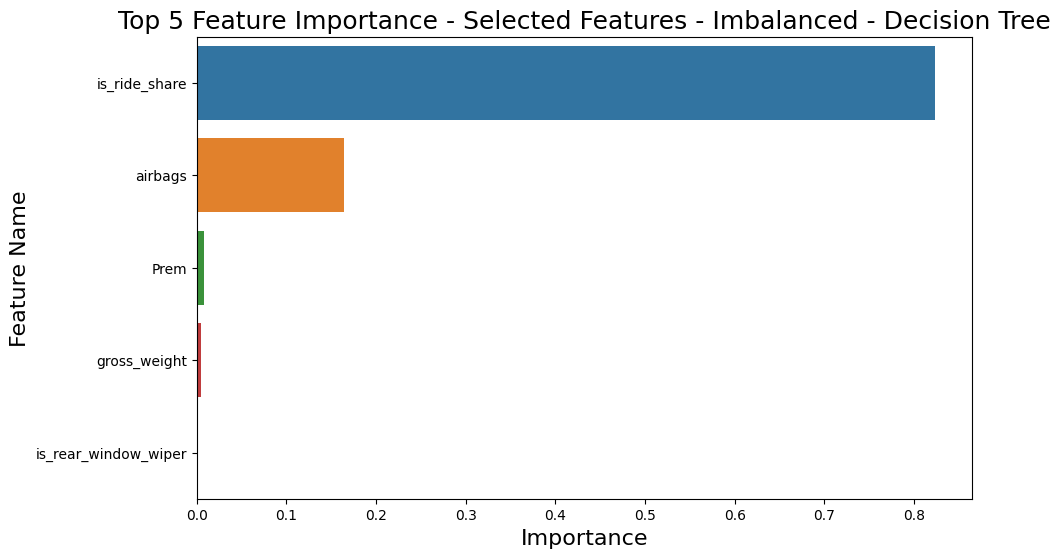

In [88]:
imp_df = pd.DataFrame(
    {"Feature Name": X_train_few.columns,
     "Importance": dt_model_few.feature_importances_})

fi = imp_df.sort_values(by="Importance", ascending=False)
fi_top5 = fi.head()

plt.figure(figsize=(10,6))
sns.barplot(data=fi_top5, x="Importance", y="Feature Name")
plt.title("Top 5 Feature Importance - Selected Features - Imbalanced - Decision Tree", fontsize=18)
plt.xlabel("Importance", fontsize=16)
plt.ylabel("Feature Name", fontsize=16)
plt.show()

## Balanced Data

### All Features

In [89]:
dt_model_confmat = confusion_matrix(y_test, dt_model_y_pred_bal)
dt_model_confmat_disp = ConfusionMatrixDisplay(confusion_matrix=dt_model_confmat,display_labels=dt_model_bal.classes_)
dt_model_confmat_disp.confusion_matrix

array([[12788,  1831],
       [  909,  2050]])

In [90]:
accuracy_score(y_test, dt_model_y_pred_bal)

0.844123335988167

In [91]:
precision_score(y_test, dt_model_y_pred_bal)

0.5282143777376964

In [92]:
recall_score(y_test, dt_model_y_pred_bal) 

0.6928016221696519

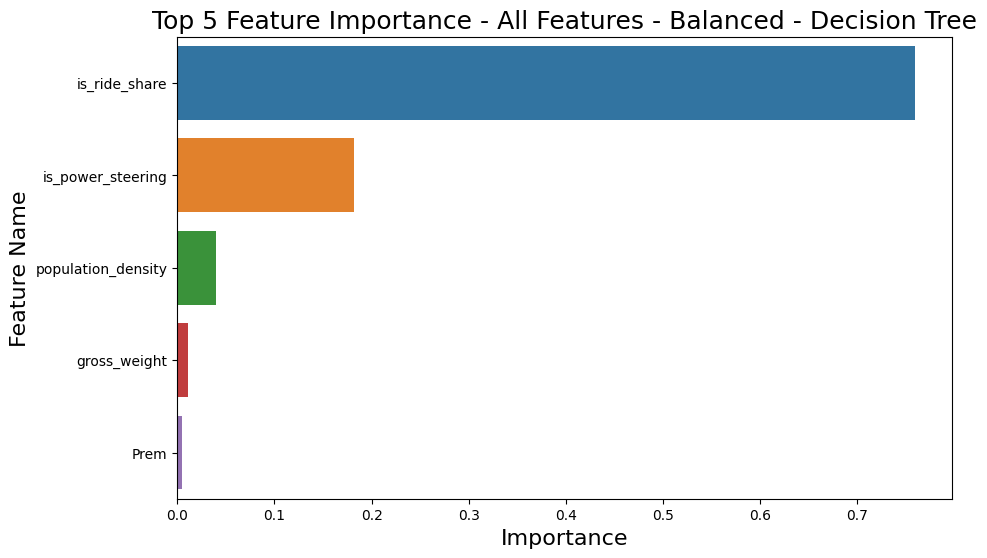

In [93]:
imp_df = pd.DataFrame(
    {"Feature Name": X_train_bal.columns,
     "Importance": dt_model_bal.feature_importances_})

fi = imp_df.sort_values(by="Importance", ascending=False)
fi_top5 = fi.head()

plt.figure(figsize=(10,6))
sns.barplot(data=fi_top5, x="Importance", y="Feature Name")
plt.title("Top 5 Feature Importance - All Features - Balanced - Decision Tree", fontsize=18)
plt.xlabel("Importance", fontsize=16)
plt.ylabel("Feature Name", fontsize=16)
plt.show()

### Selected Features

In [94]:
dt_model_confmat = confusion_matrix(y_test_few, dt_model_y_pred_bal_few)
dt_model_confmat_disp = ConfusionMatrixDisplay(confusion_matrix=dt_model_confmat,display_labels=dt_model_bal_few.classes_)
dt_model_confmat_disp.confusion_matrix

array([[13039,  1580],
       [ 1001,  1958]])

In [95]:
accuracy_score(y_test_few, dt_model_y_pred_bal_few)

0.8531687336443281

In [96]:
precision_score(y_test_few, dt_model_y_pred_bal_few)

0.5534200113058225

In [97]:
recall_score(y_test_few, dt_model_y_pred_bal_few) 

0.6617100371747212

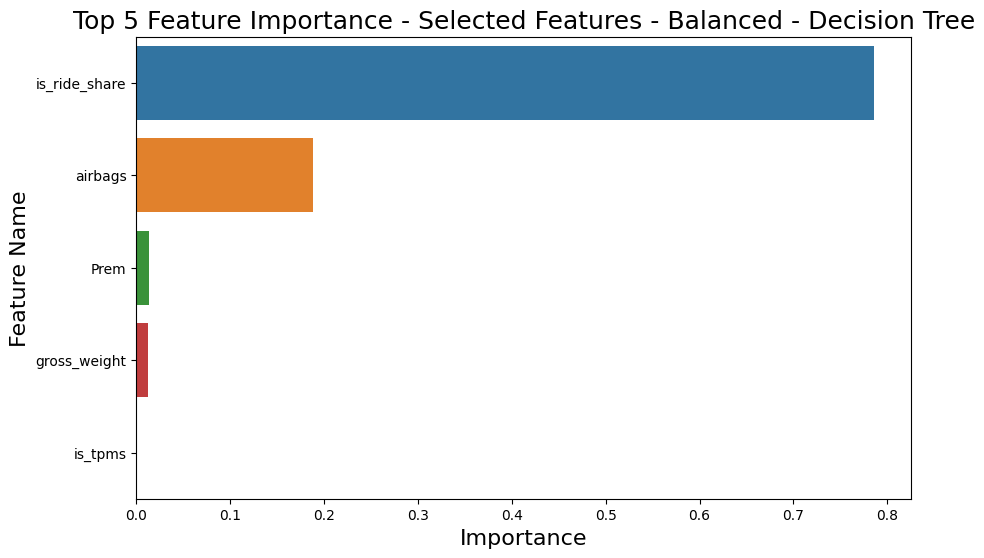

In [98]:
imp_df = pd.DataFrame(
    {"Feature Name": X_train_bal_few.columns,
     "Importance": dt_model_bal_few.feature_importances_})

fi = imp_df.sort_values(by="Importance", ascending=False)
fi_top5 = fi.head()

plt.figure(figsize=(10,6))
sns.barplot(data=fi_top5, x="Importance", y="Feature Name")
plt.title("Top 5 Feature Importance - Selected Features - Balanced - Decision Tree", fontsize=18)
plt.xlabel("Importance", fontsize=16)
plt.ylabel("Feature Name", fontsize=16)
plt.show()

# Model Selection - RF

## Imbalanced Data

### All Features

In [99]:
rf_model = RandomForestClassifier(max_depth=4)
rf_model.fit(X_train, y_train)
rf_model_y_pred = rf_model.predict(X_test)

#### test fo over/under fitting

In [100]:
rf_model_y_pred_test = rf_model.predict(X_test)
rf_model_y_pred_train = rf_model.predict(X_train)

test_acc = accuracy_score(y_test, rf_model_y_pred_test)
train_acc = accuracy_score(y_train, rf_model_y_pred_train)

print("Train accuracy:", train_acc)
print("Test accuracy:", test_acc)

Train accuracy: 0.8466621153752377
Test accuracy: 0.8445215610422119


### Selected Features

In [101]:
rf_model_few = RandomForestClassifier(max_depth=4)
rf_model_few.fit(X_train_few, y_train_few)
rf_model_y_pred_few = rf_model_few.predict(X_test_few)

#### test fo over/under fitting

In [102]:
rf_model_y_pred_few_test = rf_model_few.predict(X_test_few)
rf_model_y_pred_few_train = rf_model_few.predict(X_train_few)

test_acc = accuracy_score(y_test, rf_model_y_pred_few_test)
train_acc = accuracy_score(y_train, rf_model_y_pred_few_train)

print("Train accuracy:", train_acc)
print("Test accuracy:", test_acc)

Train accuracy: 0.8568293753352514
Test accuracy: 0.8524291728296735


## Balanced Data

### All Features

In [103]:
rf_model_bal = RandomForestClassifier(max_depth=4)
rf_model_bal.fit(X_train_bal, y_train_bal)
rf_model_y_pred_bal = rf_model_bal.predict(X_test)

#### test fo over/under fitting

In [104]:
rf_model_y_pred_bal_test = rf_model_bal.predict(X_test)
rf_model_y_pred_bal_train = rf_model_bal.predict(X_train)

test_acc = accuracy_score(y_test, rf_model_y_pred_bal_test)
train_acc = accuracy_score(y_train, rf_model_y_pred_bal_train)

print("Train accuracy:", train_acc)
print("Test accuracy:", test_acc)

Train accuracy: 0.8244501877407714
Test accuracy: 0.818636932529298


### Selected Features

In [105]:
rf_model_bal_few = RandomForestClassifier(max_depth=4)
rf_model_bal_few.fit(X_train_bal_few, y_train_bal_few)
rf_model_y_pred_bal_few = rf_model_bal_few.predict(X_test_few)

#### test fo over/under fitting

In [106]:
rf_model_y_pred_bal_few_test = rf_model_bal_few.predict(X_test_few)
rf_model_y_pred_bal_few_train = rf_model_bal_few.predict(X_train_few)

test_acc = accuracy_score(y_test, rf_model_y_pred_bal_few_test)
train_acc = accuracy_score(y_train, rf_model_y_pred_bal_few_train)

print("Train accuracy:", train_acc)
print("Test accuracy:", test_acc)

Train accuracy: 0.8568537572536207
Test accuracy: 0.8531118443508932


# Evaluation - RF

## Imbalanced Data

### All Features

In [107]:
rf_model_confmat = confusion_matrix(y_test, rf_model_y_pred)
rf_model_confmat_disp = ConfusionMatrixDisplay(confusion_matrix=rf_model_confmat,display_labels=rf_model.classes_)
rf_model_confmat_disp.confusion_matrix

array([[14355,   264],
       [ 2469,   490]])

In [108]:
accuracy_score(y_test, rf_model_y_pred)

0.8445215610422119

In [109]:
precision_score(y_test, rf_model_y_pred)

0.649867374005305

In [110]:
recall_score(y_test, rf_model_y_pred) 

0.16559648529908752

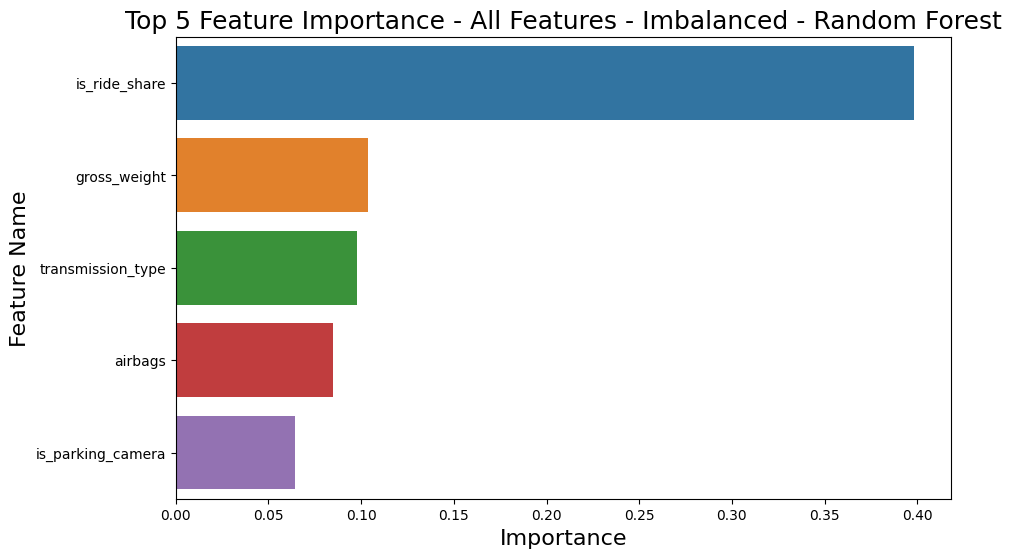

In [111]:
imp_df = pd.DataFrame(
    {"Feature Name": X_train.columns,
     "Importance": rf_model.feature_importances_})

fi = imp_df.sort_values(by="Importance", ascending=False)
fi_top5 = fi.head()

plt.figure(figsize=(10,6))
sns.barplot(data=fi_top5, x="Importance", y="Feature Name")
plt.title("Top 5 Feature Importance - All Features - Imbalanced - Random Forest", fontsize=18)
plt.xlabel("Importance", fontsize=16)
plt.ylabel("Feature Name", fontsize=16)
plt.show()

### Selected Features

In [112]:
rf_model_confmat = confusion_matrix(y_test_few, rf_model_y_pred_few)
rf_model_confmat_disp = ConfusionMatrixDisplay(confusion_matrix=rf_model_confmat,display_labels=rf_model.classes_)
rf_model_confmat_disp.confusion_matrix

array([[13408,  1211],
       [ 1383,  1576]])

In [113]:
accuracy_score(y_test_few, rf_model_y_pred_few)

0.8524291728296735

In [114]:
precision_score(y_test_few, rf_model_y_pred_few)

0.5654825977753857

In [115]:
recall_score(y_test_few, rf_model_y_pred_few) 

0.5326123690435958

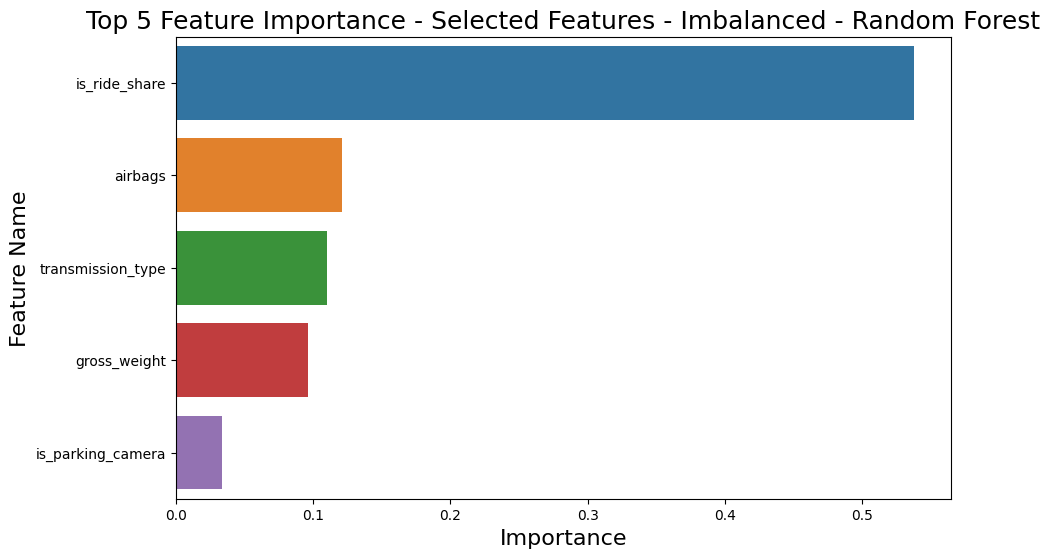

In [116]:
imp_df = pd.DataFrame(
    {"Feature Name": X_train_few.columns,
     "Importance": rf_model_few.feature_importances_})

fi = imp_df.sort_values(by="Importance", ascending=False)
fi_top5 = fi.head()

plt.figure(figsize=(10,6))
sns.barplot(data=fi_top5, x="Importance", y="Feature Name")
plt.title("Top 5 Feature Importance - Selected Features - Imbalanced - Random Forest", fontsize=18)
plt.xlabel("Importance", fontsize=16)
plt.ylabel("Feature Name", fontsize=16)
plt.show()

## Balanced Data

### All Features

In [117]:
rf_model_confmat = confusion_matrix(y_test, rf_model_y_pred_bal)
rf_model_confmat_disp = ConfusionMatrixDisplay(confusion_matrix=rf_model_confmat,display_labels=rf_model_bal.classes_)
rf_model_confmat_disp.confusion_matrix

array([[12328,  2291],
       [  897,  2062]])

In [118]:
accuracy_score(y_test, rf_model_y_pred_bal)

0.818636932529298

In [119]:
precision_score(y_test, rf_model_y_pred_bal)

0.4736963014013324

In [120]:
recall_score(y_test, rf_model_y_pred_bal) 

0.6968570462994255

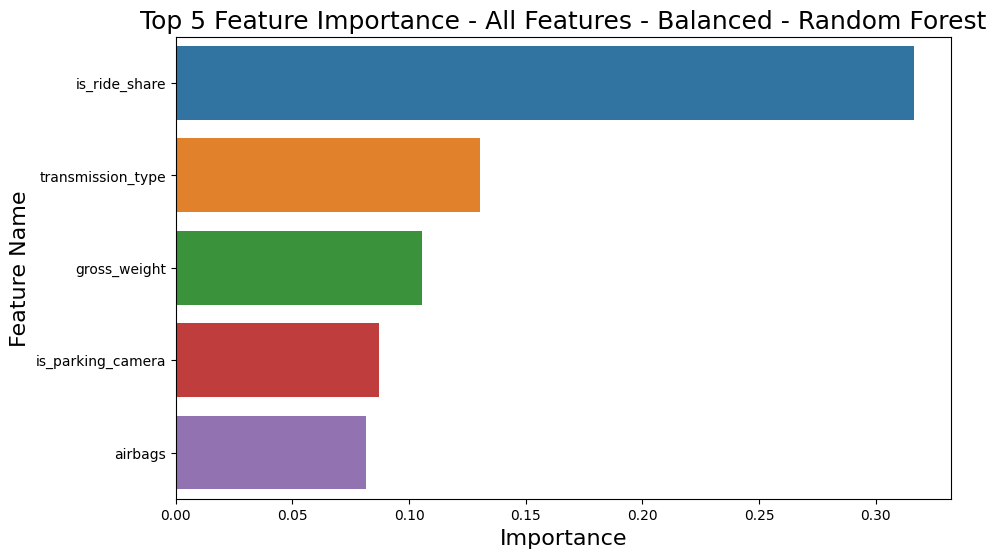

In [121]:
imp_df = pd.DataFrame(
    {"Feature Name": X_train_bal.columns,
     "Importance": rf_model_bal.feature_importances_})

fi = imp_df.sort_values(by="Importance", ascending=False)
fi_top5 = fi.head()

plt.figure(figsize=(10,6))
sns.barplot(data=fi_top5, x="Importance", y="Feature Name")
plt.title("Top 5 Feature Importance - All Features - Balanced - Random Forest", fontsize=18)
plt.xlabel("Importance", fontsize=16)
plt.ylabel("Feature Name", fontsize=16)
plt.show()

### Selected Features

In [122]:
rf_model_confmat = confusion_matrix(y_test_few, rf_model_y_pred_bal_few)
rf_model_confmat_disp = ConfusionMatrixDisplay(confusion_matrix=rf_model_confmat,display_labels=rf_model_bal_few.classes_)
rf_model_confmat_disp.confusion_matrix

array([[13040,  1579],
       [ 1003,  1956]])

In [123]:
accuracy_score(y_test_few, rf_model_y_pred_bal_few)

0.8531118443508932

In [124]:
precision_score(y_test_few, rf_model_y_pred_bal_few)

0.5533239038189534

In [125]:
recall_score(y_test_few, rf_model_y_pred_bal_few) 

0.6610341331530922

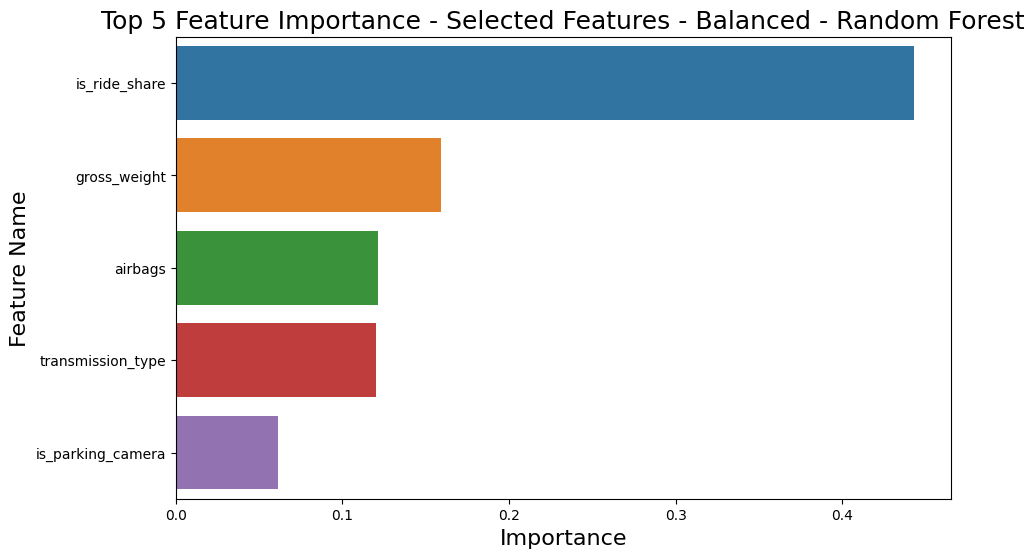

In [126]:
imp_df = pd.DataFrame(
    {"Feature Name": X_train_bal_few.columns,
     "Importance": rf_model_bal_few.feature_importances_})

fi = imp_df.sort_values(by="Importance", ascending=False)
fi_top5 = fi.head()

plt.figure(figsize=(10,6))
sns.barplot(data=fi_top5, x="Importance", y="Feature Name")
plt.title("Top 5 Feature Importance - Selected Features - Balanced - Random Forest", fontsize=18)
plt.xlabel("Importance", fontsize=16)
plt.ylabel("Feature Name", fontsize=16)
plt.show()